##### 선형 다항회귀(선형 vs 과적합)
 - 입력x 다항 특성으로 변환 x + X^2 + x^3 .. X^d
 - 선형모델(가중치 벡터)로 예측(다항회귀.. 사실상 선형회귀 다만 입력값이 다항으로 변환)
 - 손실 : MSE + L2규제(Ridge)  optimize의 weight_decay로 구현
 - 작은데이터 10개 만들어서 degree = 1  degree=10  : 선형 vs 고차원

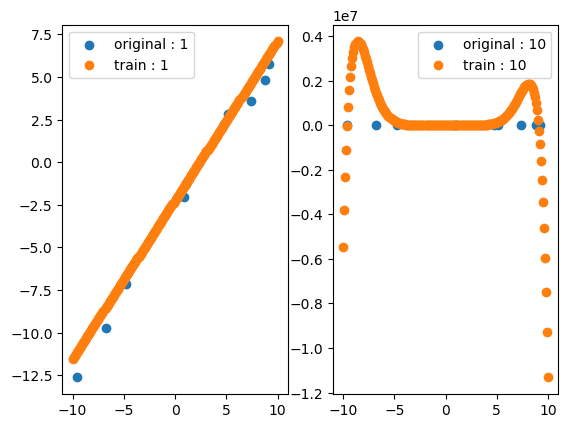

In [27]:
import numpy as np
def f(x):
    return 0.5 * x
X_plot = np.linspace(-10,10,200)
X = np.linspace(-10,10,100)
rng = np.random.RandomState(0)
rng.shuffle(X)
X = np.sort(X[:10])
noise = [ (-2 + np.random.random())*2 for _ in range(len(X))]
y = X + noise

# numpy -> tensor  (N ,1)
X_train_np = X[:, None]
y_train_np = y[:, None]
X_plot_np = X_plot[:,None]

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device)
X_plot = torch.tensor(X_plot_np, dtype=torch.float32, device=device)

# 다항 특징 생성
def poly_feature(X, degree):
    '''
        # X : torch tensor( N , 1)
        # 반환: (N, degree+1)        
    '''
    N = X.shape[0]
    feature = [torch.ones( (N,1), device=X.device )]
    for d in range(1,degree+1):
        feature.append(X**d)
    return torch.cat(feature, dim=1)

import torch.nn as nn
class LinearModel(nn.Module):
    def __init__(self,in_feature):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_feature,1)
    def forward(self ,x):
        return self.linear(x)
def train_regression(X,y,degree, lr = 1e-3, epochs=2000, weigh_decay = 1e-2): # L2 (Riddge)
    phi = poly_feature(X,degree)
    model = LinearModel(phi.shape[1]).to(device)
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weigh_decay)
    for epoch in range(epochs):
        optim.zero_grad()
        model.train()
        pred = model(phi)
        loss  = criterion(pred, y)
        loss.backward()
        optim.step()
    return model

import matplotlib.pyplot as plt
degree = [1,10]
for i , deg in enumerate(degree):
    model = train_regression(X_train, y_train,degree = deg)
    with torch.no_grad():
        phi_poly = poly_feature(X_plot.to(device), deg)
        y_plot = model(phi_poly).cpu().numpy().ravel()
    plt.subplot(1,2,i+1)
    plt.scatter(X,y,label = f'original : {deg}')
    plt.scatter(X_plot_np, y_plot, label = f"train : {deg}")
    plt.legend()
    

In [10]:
sample = poly_feature(torch.tensor( [[1],[2]] ),5)
torch.tensor( [[1],[2]] ).size(), sample.size()

(torch.Size([2, 1]), torch.Size([2, 6]))